1. Download/Load SP500 stocks prices data.

In [44]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
from alpha_vantage.timeseries import TimeSeries
import quandl
warnings.filterwarnings('ignore') 

In [45]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-12-31'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%***********************]  503 of 503 completed


Price                   close        high         low        open       volume
date       ticker                                                             
2017-01-03 A        43.743874   43.988514   43.038176   43.216951    1739600.0
           AAPL     26.891958   26.933633   26.570135   26.810924  115127600.0
           ABBV     44.265285   44.705030   43.931930   44.627010    9328200.0
           ABT      33.788067   33.814027   33.173739   33.424663    9677300.0
           ACGL     28.629999   29.143333   28.506666   28.943333     942900.0
...                       ...         ...         ...         ...          ...
2024-12-30 XYL     116.279999  116.800003  115.160004  116.459999     586800.0
           YUM     133.520004  134.410004  133.000000  134.130005    1144600.0
           ZBH     105.400002  106.349998  104.650002  106.050003    1532000.0
           ZBRA    383.850006  386.959991  378.149994  385.059998     211300.0
           ZTS     162.240005  164.050003  161.449997  163.889999    1531400.0

[991757 rows x 5 columns]

2. Calculate features and technical indicators for each stock.
    Garman-Klass Volatility
    RSI
    Bollinger Bands
    ATR
    MACD
    Dollar Volume

In [46]:
# Ensure 'adj close' exists; fallback to 'close' if not
if 'adj close' not in df.columns:
    df['adj close'] = df['close']

# Compute Garman-Klass Volatility
df['garman_klass_vol'] = (
    ((np.log(df['high']) - np.log(df['low'])) ** 2) / 2 -
    (2 * np.log(2) - 1) * ((np.log(df['adj close']) - np.log(df['open'])) ** 2)
)

# Compute RSI
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

# Compute Bollinger Bands
def compute_bbands(group):
    bb = pandas_ta.bbands(close=np.log1p(group), length=20)
    return pd.DataFrame({
        'bb_low': bb.iloc[:, 0],
        'bb_mid': bb.iloc[:, 1],
        'bb_high': bb.iloc[:, 2]
    }, index=group.index)

# Apply Bollinger Bands computation
bb_result = df.groupby(level=1)['adj close'].apply(compute_bbands)
bb_result = bb_result.reset_index(level=0, drop=True)  # Drop the group level to align indices

# Merge the result back into the original DataFrame
df = df.join(bb_result)


# Compute ATR
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['close'], length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

# Compute MACD
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:, 0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

# Compute Dollar Volume
df['dollar_volume'] = (df['adj close'] * df['volume']) / 1e6

# Display DataFrame
df

close        high         low        open  \
date       ticker                                                   
2017-01-03 A        43.743874   43.988514   43.038176   43.216951   
           AAPL     26.891958   26.933633   26.570135   26.810924   
           ABBV     44.265285   44.705030   43.931930   44.627010   
           ABT      33.788067   33.814027   33.173739   33.424663   
           ACGL     28.629999   29.143333   28.506666   28.943333   
...                       ...         ...         ...         ...   
2024-12-30 XYL     116.279999  116.800003  115.160004  116.459999   
           YUM     133.520004  134.410004  133.000000  134.130005   
           ZBH     105.400002  106.349998  104.650002  106.050003   
           ZBRA    383.850006  386.959991  378.149994  385.059998   
           ZTS     162.240005  164.050003  161.449997  163.889999   

                        volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                         
2017-01-03 A         1739600.0   43.743874          0.000182        NaN   
           AAPL    115127600.0   26.891958          0.000089        NaN   
           ABBV      9328200.0   44.265285          0.000127        NaN   
           ABT       9677300.0   33.788067          0.000138        NaN   
           ACGL       942900.0   28.629999          0.000198        NaN   
...                        ...         ...               ...        ...   
2024-12-30 XYL        586800.0  116.279999          0.000099  35.220231   
           YUM       1144600.0  133.520004          0.000048  45.822896   
           ZBH       1532000.0  105.400002          0.000115  43.454505   
           ZBRA       211300.0  383.850006          0.000261  45.199475   
           ZTS       1531400.0  162.240005          0.000088  32.695541   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2017-01-03 A            NaN       NaN       NaN       NaN       NaN   
           AAPL         NaN       NaN       NaN       NaN       NaN   
           ABBV         NaN       NaN       NaN       NaN       NaN   
           ABT          NaN       NaN       NaN       NaN       NaN   
           ACGL         NaN       NaN       NaN       NaN       NaN   
...                     ...       ...       ...       ...       ...   
2024-12-30 XYL     4.737243  4.810611  4.883978  0.564759 -1.610867   
           YUM     4.881771  4.919700  4.957628  0.760885 -0.595618   
           ZBH     4.658380  4.686718  4.715055 -0.604254 -0.307769   
           ZBRA    5.946061  5.992536  6.039010  0.077356 -0.332876   
           ZTS     5.080445  5.150556  5.220666  0.413517 -1.758412   

                   dollar_volume  
date       ticker                 
2017-01-03 A           76.096843  
           AAPL      3096.006611  
           ABBV       412.915436  
           ABT        326.977259  
           ACGL        26.995226  
...                          ...  
2024-12-30 XYL         68.233103  
           YUM        152.826997  
           ZBH        161.472802  
           ZBRA        81.107506  
           ZTS        248.454344  

[991757 rows x 14 columns]

3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

In [47]:
# To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-02-28 A           98.277647   48.269749          0.000026  63.191801   
           AAPL      3730.196969   31.854519          0.000014  88.716032   
           ABBV       293.042513   44.303558          0.000058  53.631428   
           ABT        332.530653   39.257488          0.000068  75.717463   
           ACGL        36.285420   31.523333          0.000039  76.812984   
...                          ...         ...               ...        ...   
2024-12-31 XYL        166.123954  116.279999          0.000099  35.220231   
           YUM        208.885559  133.520004          0.000048  45.822896   
           ZBH        165.466038  105.400002          0.000115  43.454505   
           ZBRA       121.040691  383.850006          0.000261  45.199475   
           ZTS        416.998762  162.240005          0.000088  32.695541   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-02-28 A       3.844027  3.881775  3.919523 -1.555729  0.284420  
           AAPL    3.400463  3.462253  3.524044 -1.449965  0.128807  
           ABBV    3.784567  3.803218  3.821869 -1.703476 -0.219910  
           ABT     3.609819  3.664647  3.719474 -1.584052  0.649834  
           ACGL    3.422038  3.460980  3.499921 -1.183670  0.374804  
...                     ...       ...       ...       ...       ...  
2024-12-31 XYL     4.737243  4.810611  4.883978  0.564759 -1.610867  
           YUM     4.881771  4.919700  4.957628  0.760885 -0.595618  
           ZBH     4.658380  4.686718  4.715055 -0.604254 -0.307769  
           ZBRA    5.946061  5.992536  6.039010  0.077356 -0.332876  
           ZTS     5.080445  5.150556  5.220666  0.413517 -1.758412  

[46845 rows x 9 columns]

In [48]:
# Calculate 5-year rolling average of dollar volume for each stocks before filtering.

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-01-31 AAPL     39.388081          0.000063  40.100710  3.695993   
           ABBV     83.089912          0.000575  62.305740  4.236627   
           ABT      55.295006          0.000082  69.274830  3.936873   
           ACN     144.842712          0.000023  63.135560  4.952747   
           ADBE    199.759995          0.000156  65.801043  5.203949   
...                       ...               ...        ...       ...   
2024-12-31 WDAY    262.000000          0.000183  49.133109  5.545855   
           WFC      70.410004          0.000107  50.026241  4.239613   
           WMT      90.570000          0.000053  51.567971  4.517318   
           XOM     105.760002          0.000039  27.759638  4.638960   
           ZTS     162.240005          0.000088  32.695541  5.080445   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2018-01-31 AAPL    3.736405  3.776816 -1.248956 -0.431365  
           ABBV    4.368567  4.500507  0.529758  1.689218  
           ABT     3.995678  4.054483 -0.985564  0.889593  
           ACN     4.976202  4.999656 -1.251162  0.243246  
           ADBE    5.268046  5.332143 -1.287861  0.408035  
...                     ...       ...       ...       ...  
2024-12-31 WDAY    5.597234  5.648614  1.241031  0.242988  
           WFC     4.286159  4.332706  1.676597 -0.263496  
           WMT     4.547918  4.578519  3.224959  0.985684  
           XOM     4.710689  4.782418  0.362700 -2.627481  
           ZTS     5.150556  5.220666  0.413517 -1.758412  

[12516 rows x 8 columns]

4. Calculate Monthly Returns for different time horizons as features.

In [49]:
# To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-01-31 AAPL     39.743027          0.000353  53.482558  3.564609   
           ABBV     62.078796          0.000419  41.951136  4.108503   
           ABT      66.100273          0.000151  56.879267  4.115729   
           ACN     140.895630          0.000067  55.082718  4.855345   
           ADBE    247.820007          0.000148  56.084696  5.412191   
...                       ...               ...        ...       ...   
2024-12-31 VZ       39.599998          0.000052  33.994226  3.681540   
           WDAY    262.000000          0.000183  49.133109  5.545855   
           WFC      70.410004          0.000107  50.026241  4.239613   
           WMT      90.570000          0.000053  51.567971  4.517318   
           XOM     105.760002          0.000039  27.759638  4.638960   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2019-01-31 AAPL    3.630896  3.697183 -0.877810 -0.382621   0.055154   
           ABBV    4.201370  4.294236 -0.026928 -1.042993  -0.118399   
           ABT     4.161145  4.206561 -0.161419  0.141218   0.013665   
           ACN     4.915819  4.976293 -0.794892  0.042718   0.088930   
           ADBE    5.478527  5.544863 -0.675544  0.205127   0.095385   
...                     ...       ...       ...       ...        ...   
2024-12-31 VZ      3.745631  3.809721 -0.168290 -1.651883  -0.106901   
           WDAY    5.597234  5.648614  1.241031  0.242988   0.048042   
           WFC     4.286159  4.332706  1.676597 -0.263496  -0.075620   
           WMT     4.547918  4.578519  3.224959  0.985684  -0.018695   
           XOM     4.710689  4.782418  0.362700 -2.627481  -0.103425   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-01-31 AAPL    -0.034589  -0.086165  -0.020933   0.001996    0.000748  
           ABBV    -0.071480   0.014454  -0.019116  -0.016684   -0.024001  
           ABT     -0.004952   0.020737   0.019565   0.027107    0.014985  
           ACN     -0.033914  -0.008682  -0.004631   0.002728   -0.002300  
           ADBE    -0.006137   0.002786   0.002128   0.012503    0.018128  
...                      ...        ...        ...        ...         ...  
2024-12-31 VZ      -0.030491  -0.036112  -0.001475  -0.001122    0.009518  
           WDAY     0.058478   0.023436   0.026797  -0.004458   -0.004347  
           WFC      0.044421   0.078250   0.031067   0.024025    0.032528  
           WMT      0.052442   0.039763   0.050561   0.047477    0.047447  
           XOM     -0.048352  -0.033712  -0.012716  -0.008671    0.006820  

[10361 rows x 14 columns]

5. Download Fama-French Factors and Calculate Rolling Factor Betas.

In [65]:
# Retrieve the Fama-French 5-factor data from the 'famafrench' source using the DataReader function.
# The data is retrieved starting from the year 2010. The [0] selects the first DataFrame from the returned data structure.
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                             'famafrench', 
                             start='2010')[0].drop('RF', axis=1)  # Drop the 'RF' (risk-free rate) column.

# Convert the index of the factor_data (which is currently a PeriodIndex) into a TimestampIndex.
factor_data.index = factor_data.index.to_timestamp()

# Resample the data to the end of each month ('M') and take the last value in each resampled period.
# Then, divide all factor values by 100 to convert percentages into decimal form.
factor_data = factor_data.resample('M').last().div(100)

# Rename the index of the DataFrame to 'date'.
factor_data.index.name = 'date'

# Join the 'return_1m' column from the `data` DataFrame with the factor_data DataFrame on the index.
# Ensure the resulting DataFrame is sorted by index.
factor_data = factor_data.join(data['return_1m']).sort_index()

# Display the resulting factor_data DataFrame.
factor_data.head(10)


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-01-31 AAPL     0.084  0.0301 -0.0045 -0.0078 -0.0152   0.055154
           ABBV     0.084  0.0301 -0.0045 -0.0078 -0.0152  -0.118399
           ABT      0.084  0.0301 -0.0045 -0.0078 -0.0152   0.013665
           ACN      0.084  0.0301 -0.0045 -0.0078 -0.0152   0.088930
           ADBE     0.084  0.0301 -0.0045 -0.0078 -0.0152   0.095385
           ADI      0.084  0.0301 -0.0045 -0.0078 -0.0152   0.151812
           ADP      0.084  0.0301 -0.0045 -0.0078 -0.0152   0.066504
           ADSK     0.084  0.0301 -0.0045 -0.0078 -0.0152   0.144545
           AMAT     0.084  0.0301 -0.0045 -0.0078 -0.0152   0.193647
           AMD      0.084  0.0301 -0.0045 -0.0078 -0.0152   0.322319

In [51]:
# Filter out stocks with less than 10 months of data.

observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-01-31 AAPL     0.084  0.0301 -0.0045 -0.0078 -0.0152   0.055154
           ABBV     0.084  0.0301 -0.0045 -0.0078 -0.0152  -0.118399
           ABT      0.084  0.0301 -0.0045 -0.0078 -0.0152   0.013665
           ACN      0.084  0.0301 -0.0045 -0.0078 -0.0152   0.088930
           ADBE     0.084  0.0301 -0.0045 -0.0078 -0.0152   0.095385
...                   ...     ...     ...     ...     ...        ...
2024-11-30 VZ       0.065  0.0478 -0.0005 -0.0261 -0.0217   0.052457
           WDAY     0.065  0.0478 -0.0005 -0.0261 -0.0217   0.069019
           WFC      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.180051
           WMT      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.128580
           XOM      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.010104

[10198 rows x 6 columns]

In [52]:
# Calculate Rolling Factor Betas.

betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-01-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-11-30 VZ      0.885481 -0.606879  0.299135  0.505724  0.276440
           WDAY    0.760453 -1.023488  0.151870 -2.489189 -0.729128
           WFC     0.723450 -0.312080  1.429828 -2.012390 -1.095390
           WMT     0.844559  0.175824 -0.332756  1.279649  0.295546
           XOM     0.610115  0.021108  0.209403  1.190127  0.729822

[10198 rows x 5 columns]

In [53]:
# Join the rolling factors data to the main features dataframe.

factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10136 entries, (Timestamp('2019-01-31 00:00:00'), 'AAPL') to (Timestamp('2024-12-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10136 non-null  float64
 1   rsi               10136 non-null  float64
 2   bb_low            10136 non-null  float64
 3   bb_mid            10136 non-null  float64
 4   bb_high           10136 non-null  float64
 5   atr               10136 non-null  float64
 6   macd              10136 non-null  float64
 7   return_1m         10136 non-null  float64
 8   return_2m         10136 non-null  float64
 9   return_3m         10136 non-null  float64
 10  return_6m         10136 non-null  float64
 11  return_9m         10136 non-null  float64
 12  return_12m        10136 non-null  float64
 13  Mkt-RF            10136 non-null  float64
 14  SMB               10136 non-null  float64
 15  HML       

At this point we have to decide on what ML model and approach to use for predictions etc.

6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
    K-Means Clustering
        You may want to initialize predefined centroids for each cluster based on your research.
        For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.
        Then we will pre-define our centroids for each cluster.

In [54]:
from sklearn.cluster import KMeans

# Check if 'cluster' column exists before dropping
if 'cluster' in data.columns:
    data = data.drop('cluster', axis=1)

def get_clusters(df):
    # Ensure initial_centroids is defined or use another initialization method
    df['cluster'] = KMeans(n_clusters=4, random_state=0, init='k-means++').fit(df).labels_
    return df

# Apply the clustering logic after dropping any rows with missing data
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

# Display the resulting data
data


garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-01-31 AAPL            0.000353  53.482558  3.564609  3.630896  3.697183   
           ABBV            0.000419  41.951136  4.108503  4.201370  4.294236   
           ABT             0.000151  56.879267  4.115729  4.161145  4.206561   
           ACN             0.000067  55.082718  4.855345  4.915819  4.976293   
           ADBE            0.000148  56.084696  5.412191  5.478527  5.544863   
...                             ...        ...       ...       ...       ...   
2024-12-31 VZ              0.000052  33.994226  3.681540  3.745631  3.809721   
           WDAY            0.000183  49.133109  5.545855  5.597234  5.648614   
           WFC             0.000107  50.026241  4.239613  4.286159  4.332706   
           WMT             0.000053  51.567971  4.517318  4.547918  4.578519   
           XOM             0.000039  27.759638  4.638960  4.710689  4.782418   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-01-31 AAPL   -0.877810 -0.382621   0.055154  -0.034589  -0.086165   
           ABBV   -0.026928 -1.042993  -0.118399  -0.071480   0.014454   
           ABT    -0.161419  0.141218   0.013665  -0.004952   0.020737   
           ACN    -0.794892  0.042718   0.088930  -0.033914  -0.008682   
           ADBE   -0.675544  0.205127   0.095385  -0.006137   0.002786   
...                     ...       ...        ...        ...        ...   
2024-12-31 VZ     -0.168290 -1.651883  -0.106901  -0.030491  -0.036112   
           WDAY    1.241031  0.242988   0.048042   0.058478   0.023436   
           WFC     1.676597 -0.263496  -0.075620   0.044421   0.078250   
           WMT     3.224959  0.985684  -0.018695   0.052442   0.039763   
           XOM     0.362700 -2.627481  -0.103425  -0.048352  -0.033712   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-01-31 AAPL    -0.020933   0.001996    0.000748  1.284949 -0.213314   
           ABBV    -0.019116  -0.016684   -0.024001  0.542394  0.283157   
           ABT      0.019565   0.027107    0.014985  0.765215 -0.038216   
           ACN     -0.004631   0.002728   -0.002300  1.200661 -0.207618   
           ADBE     0.002128   0.012503    0.018128  1.320832 -0.574099   
...                      ...        ...         ...       ...       ...   
2024-12-31 VZ      -0.001475  -0.001122    0.009518  0.472635 -0.492993   
           WDAY     0.026797  -0.004458   -0.004347  1.188695 -0.651057   
           WFC      0.031067   0.024025    0.032528  1.115929 -0.110873   
           WMT      0.050561   0.047477    0.047447  0.639809 -0.336385   
           XOM     -0.012716  -0.008671    0.006820  0.995730  0.039250   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-01-31 AAPL   -0.635462  0.321482  0.466817        1  
           ABBV   -0.141002  0.390132  0.526258        3  
           ABT    -0.437932  0.147857  1.010506        2  
           ACN    -0.220469  0.349132 -0.003319        1  
           ADBE   -0.251690  0.315376 -0.420837        2  
...                     ...       ...       ...      ...  
2024-12-31 VZ      0.310550  0.134558  0.078485        2  
           WDAY   -0.381560 -0.894224 -0.284504        3  
           WFC     1.586595 -0.685854 -1.000627        3  
           WMT    -0.360346  0.198306  0.603114        3  
           XOM     0.906733 -0.456898  0.353222        2  

[10136 rows x 19 columns]

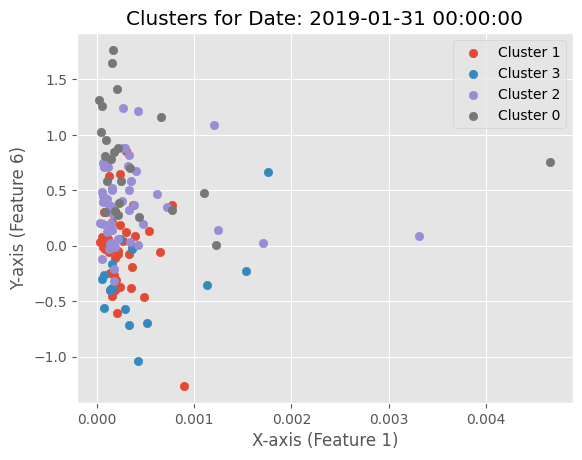

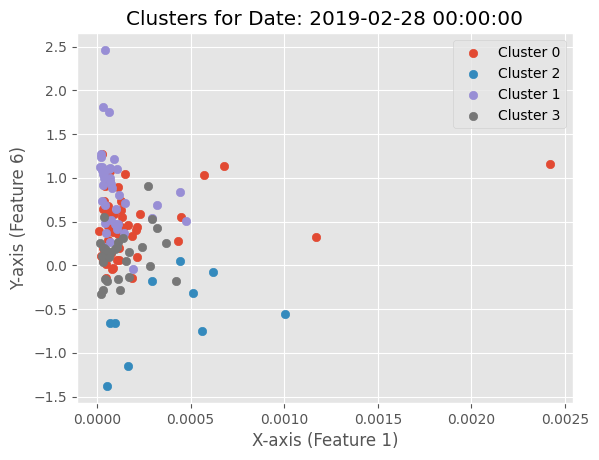

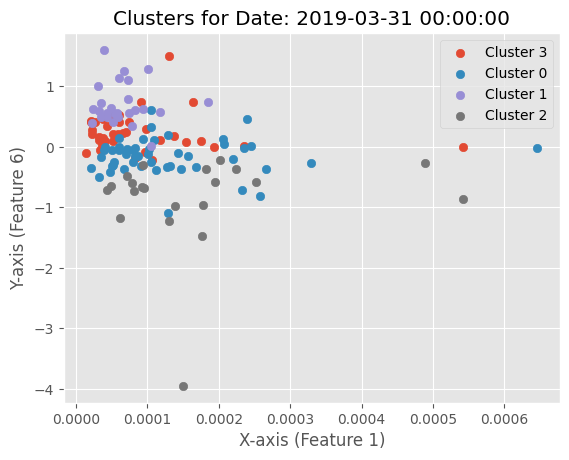

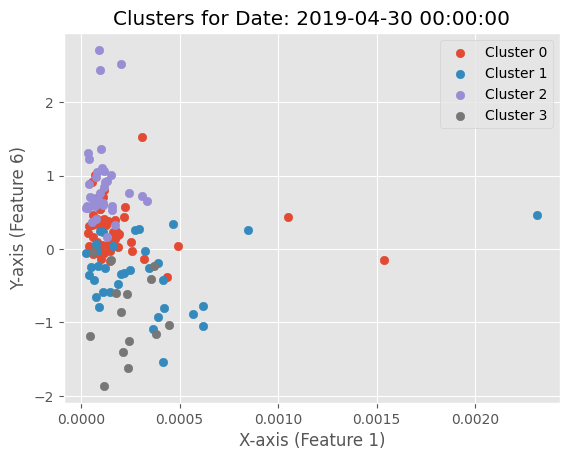

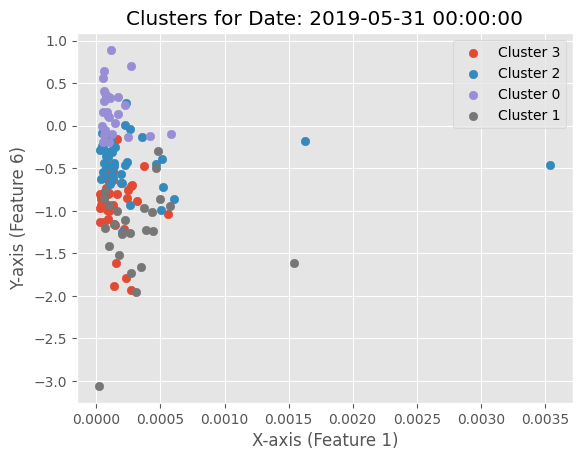

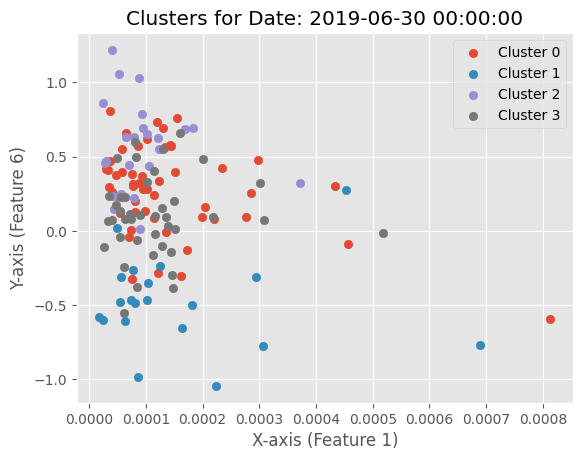

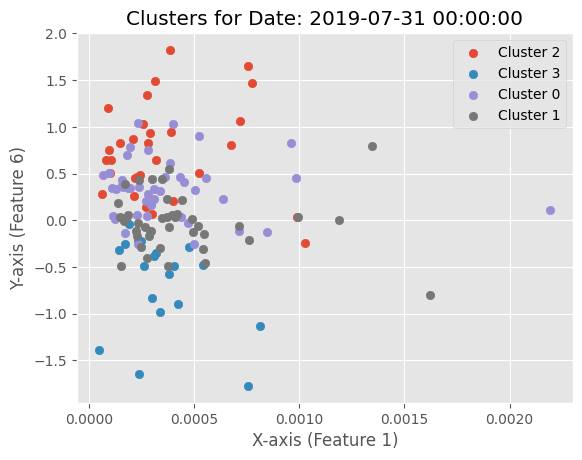

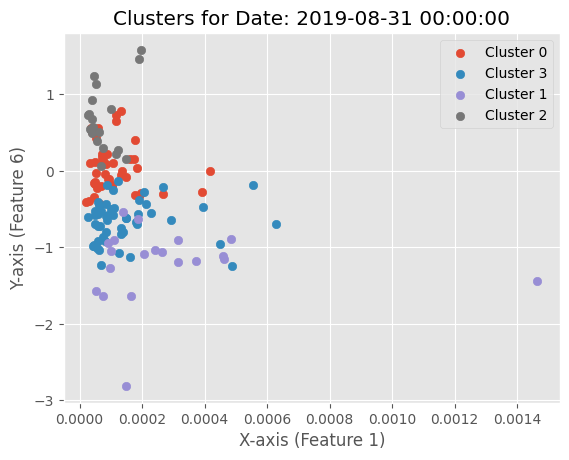

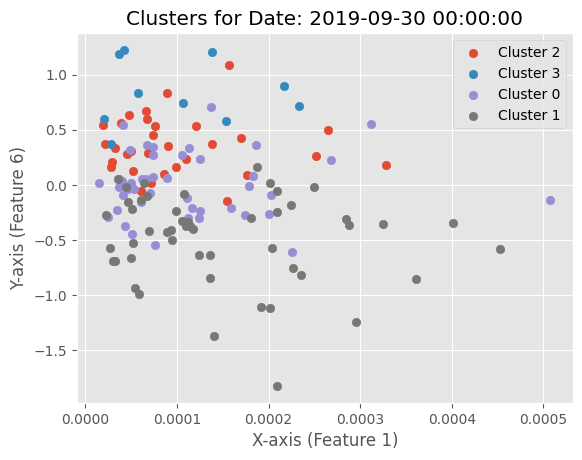

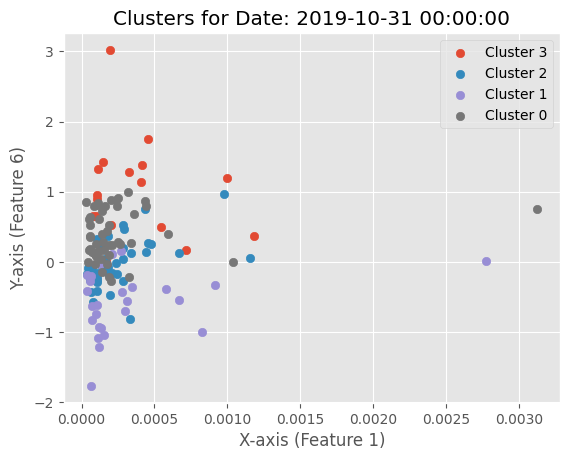

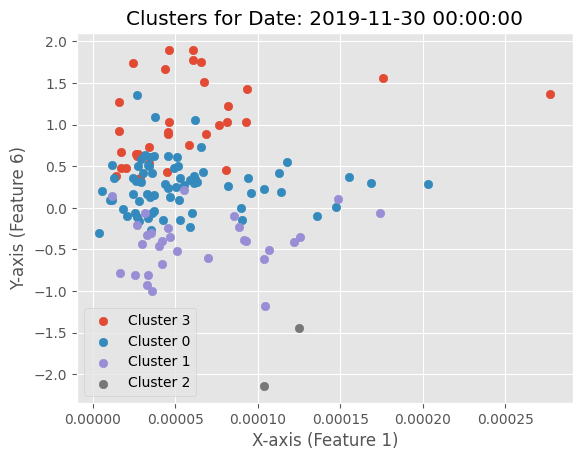

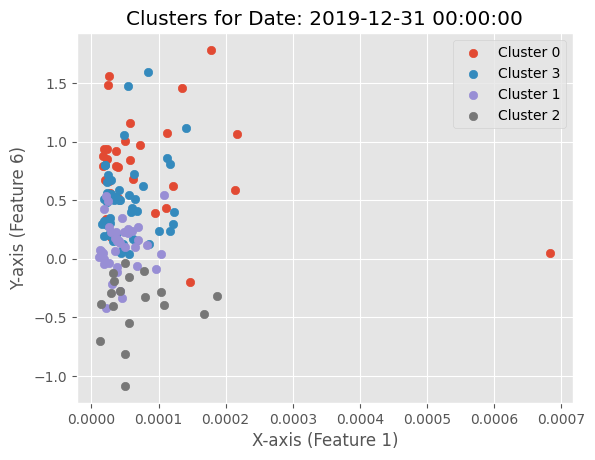

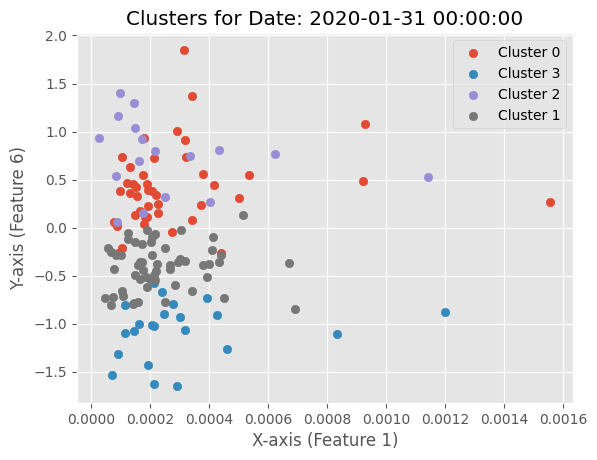

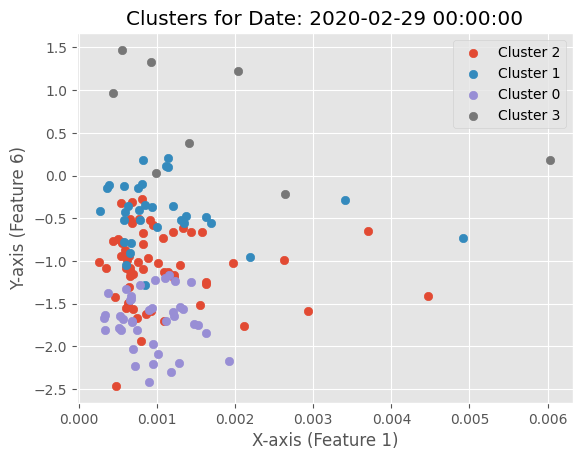

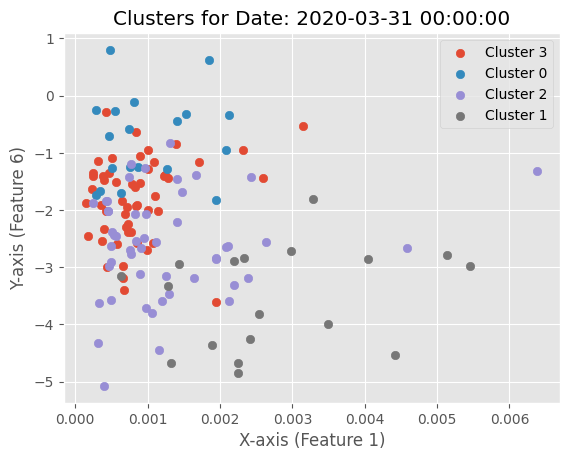

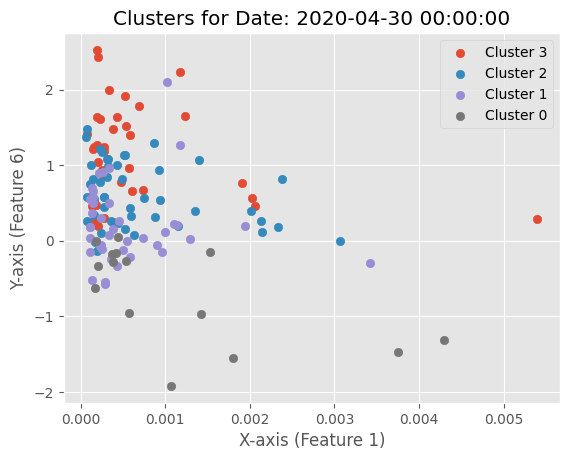

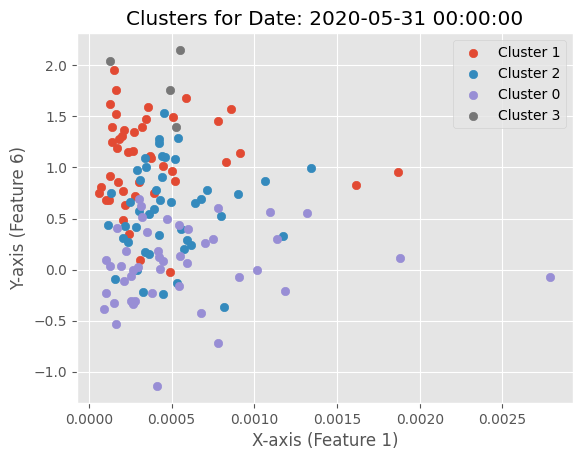

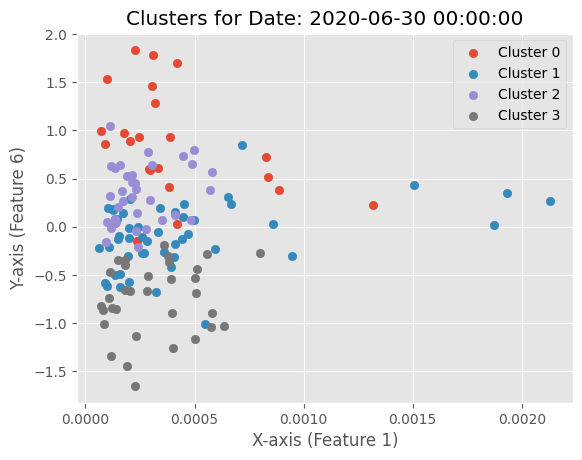

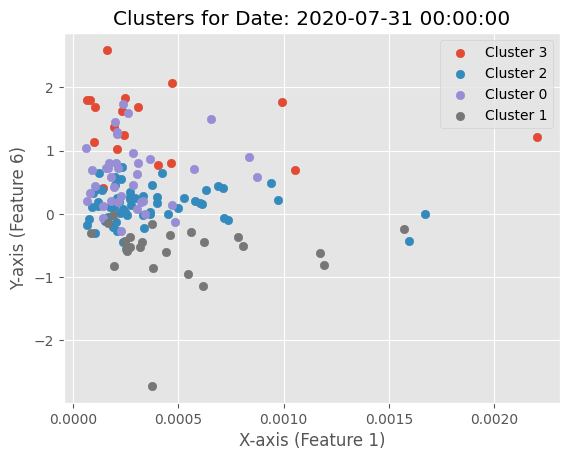

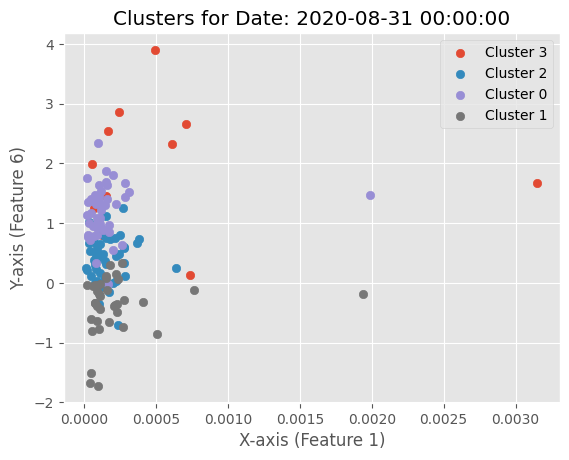

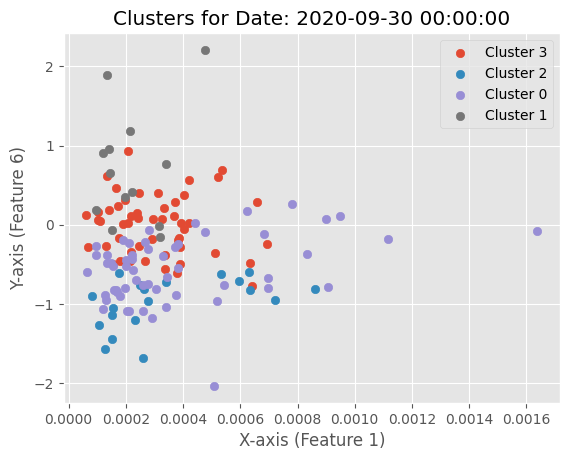

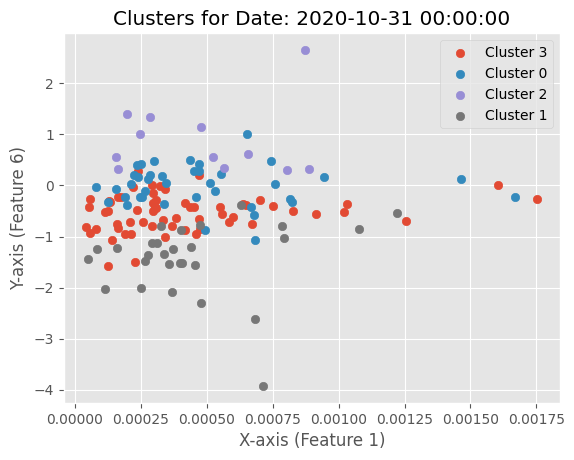

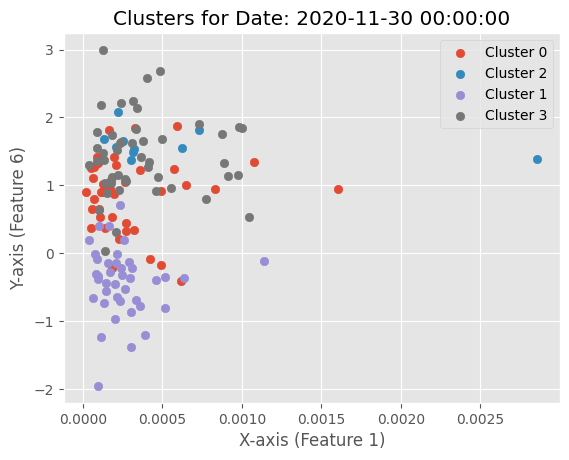

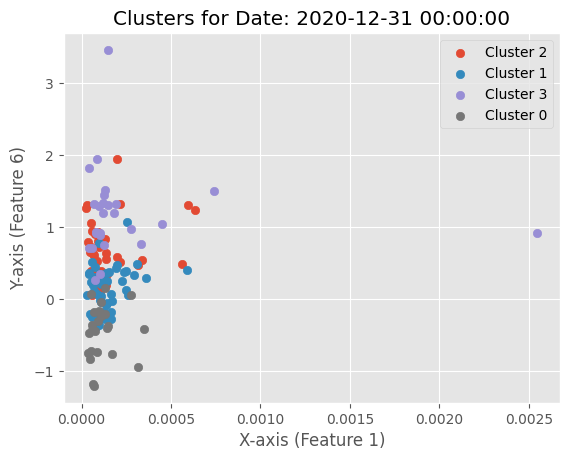

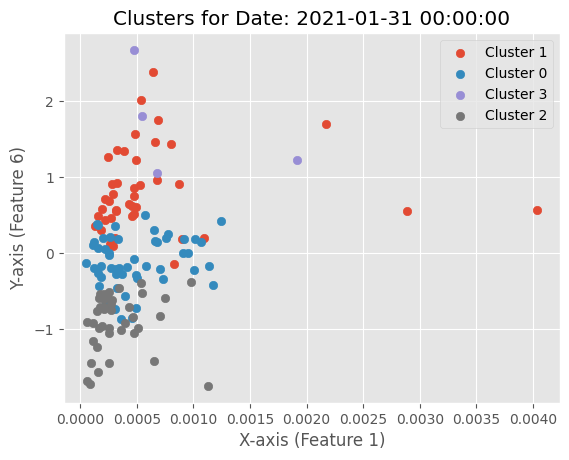

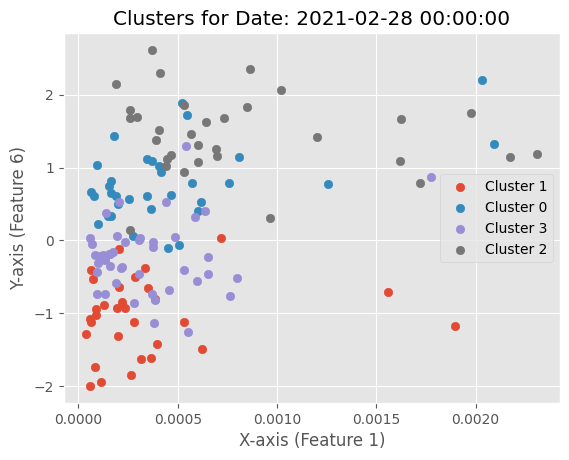

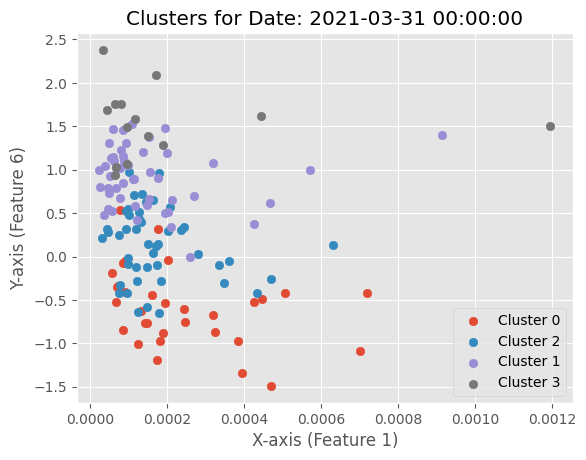

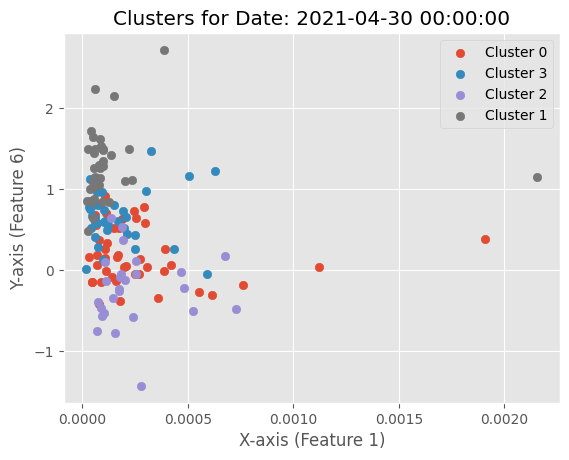

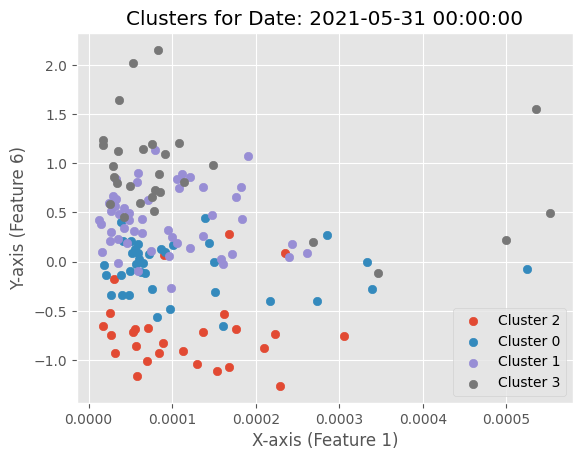

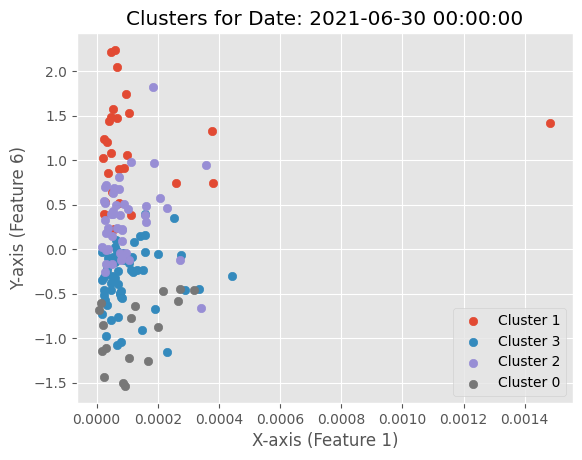

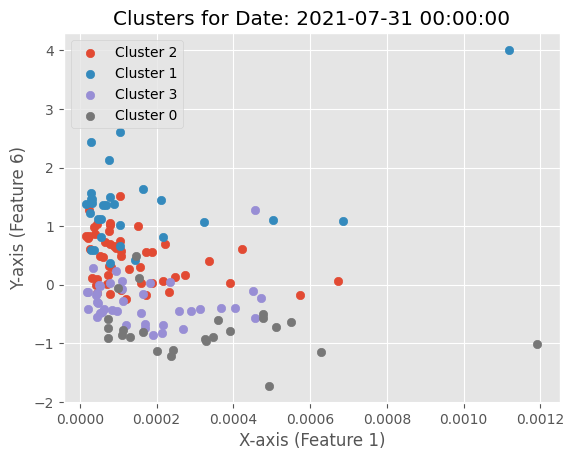

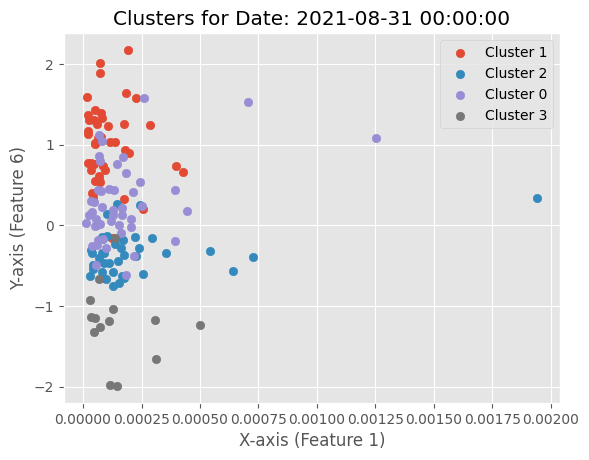

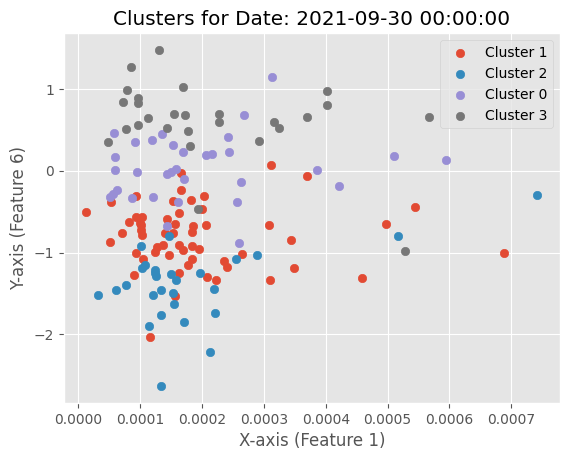

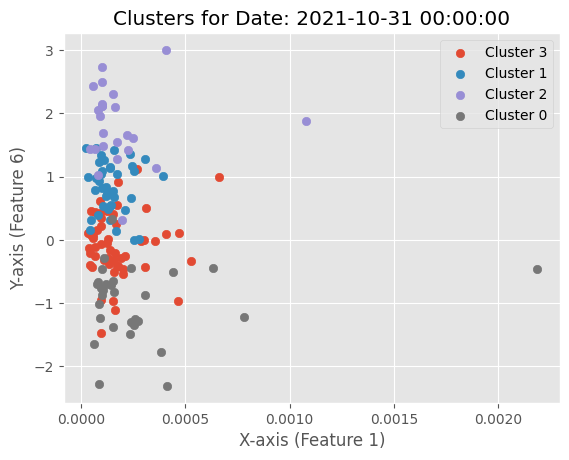

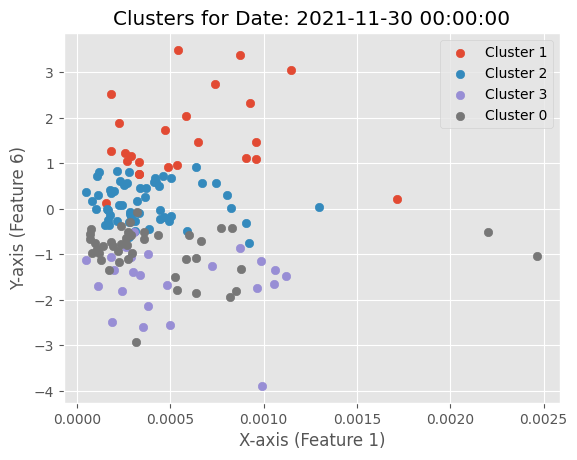

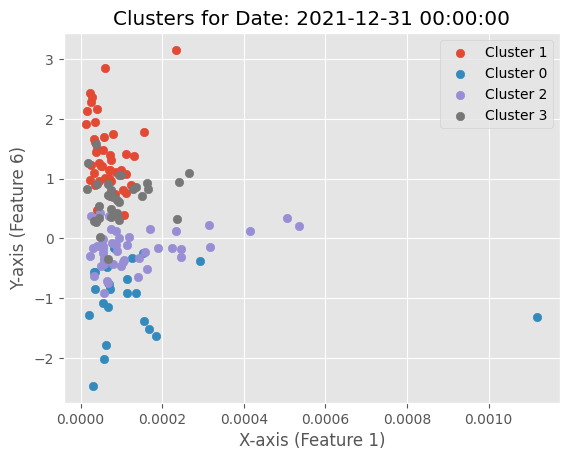

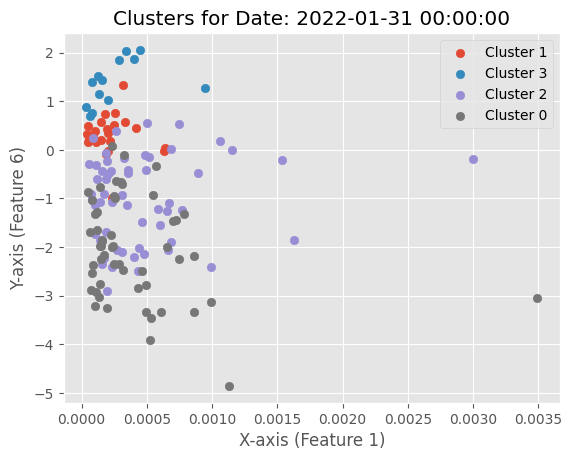

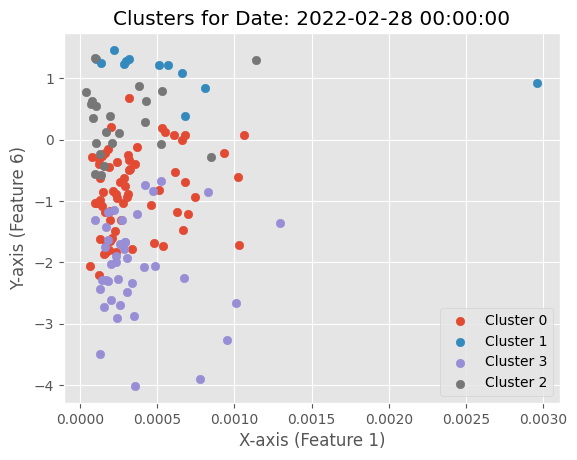

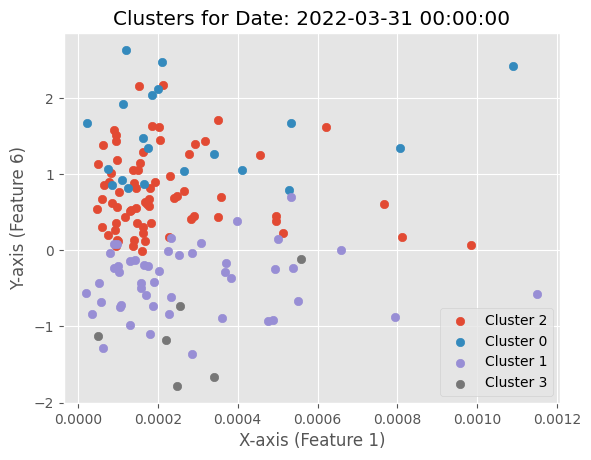

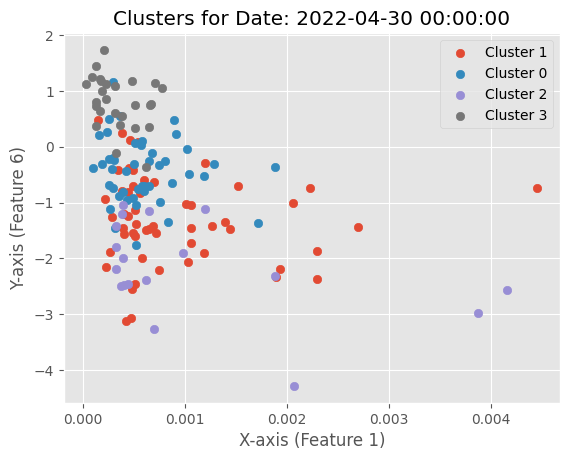

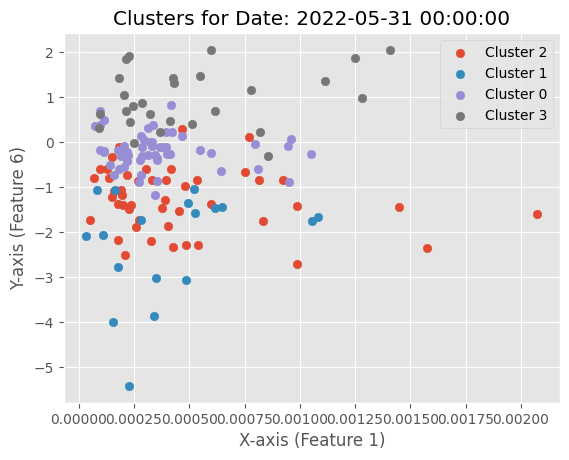

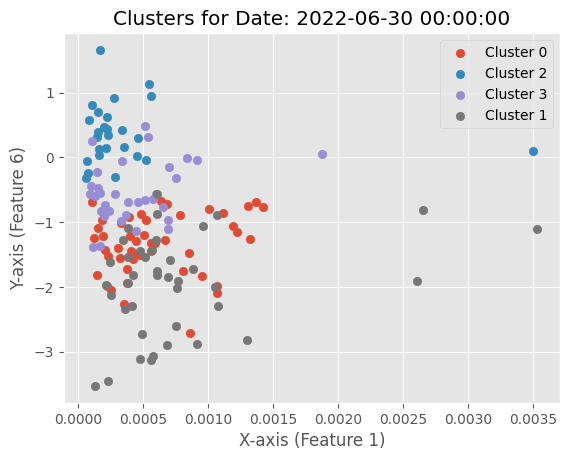

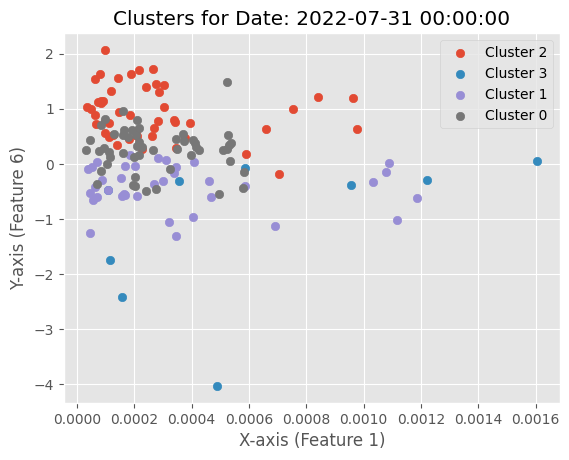

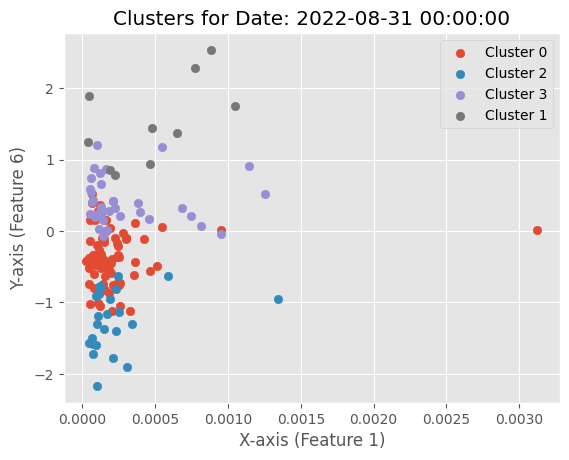

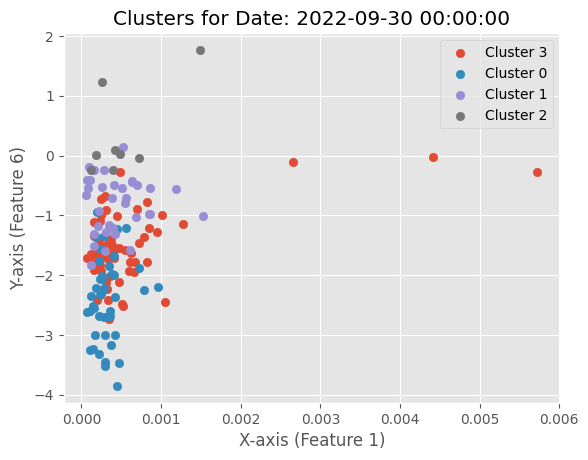

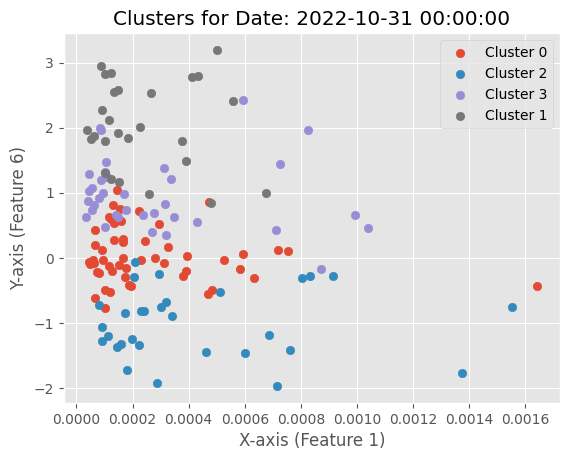

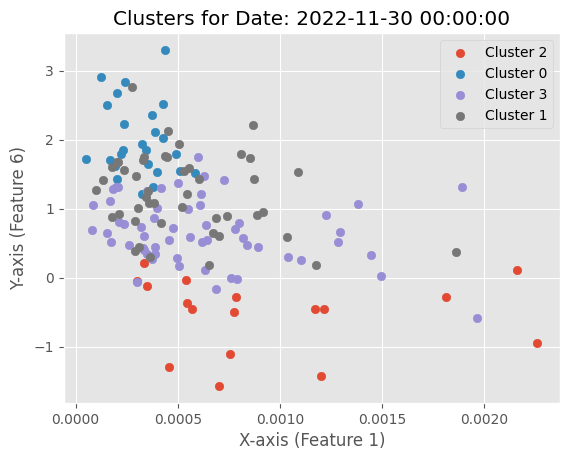

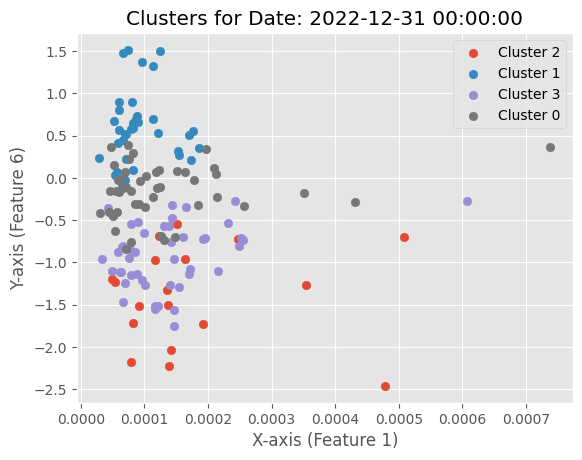

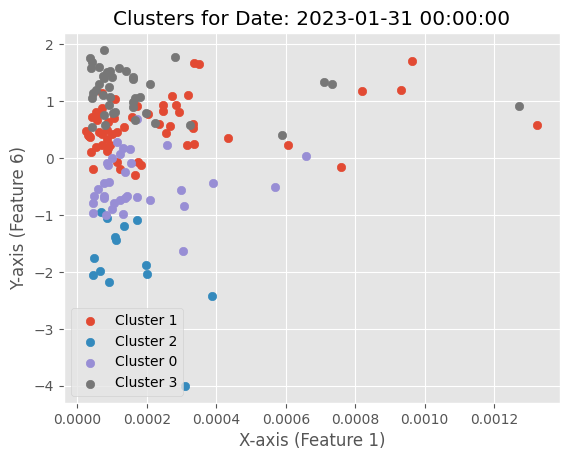

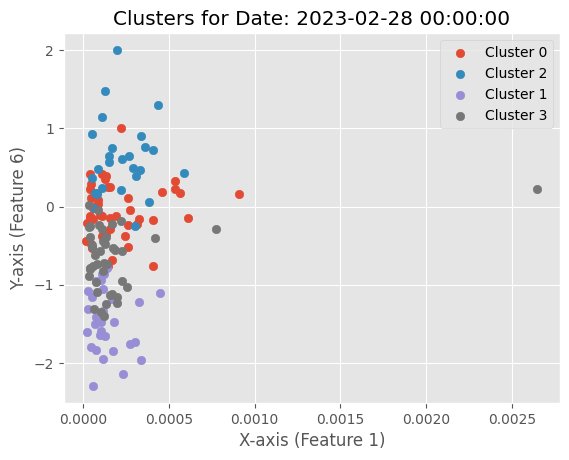

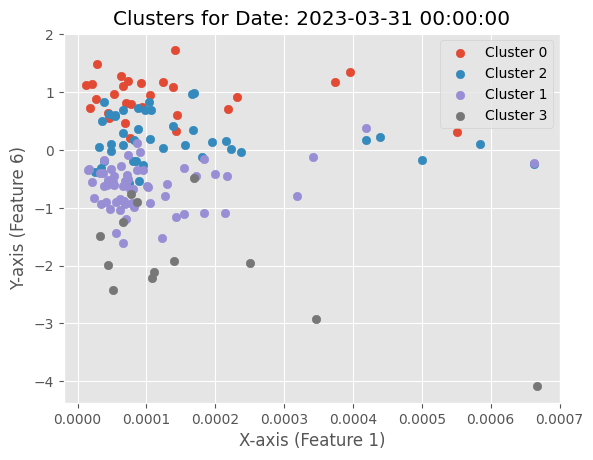

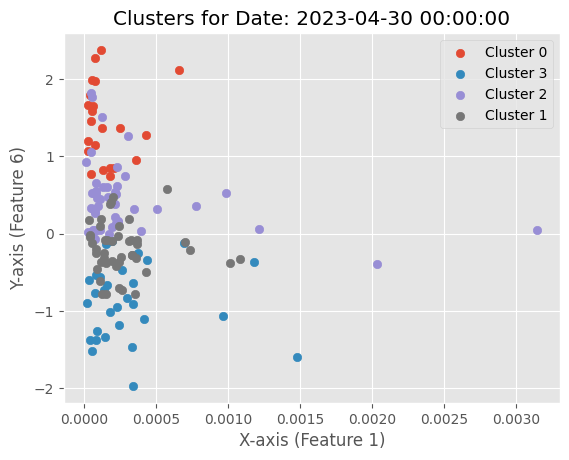

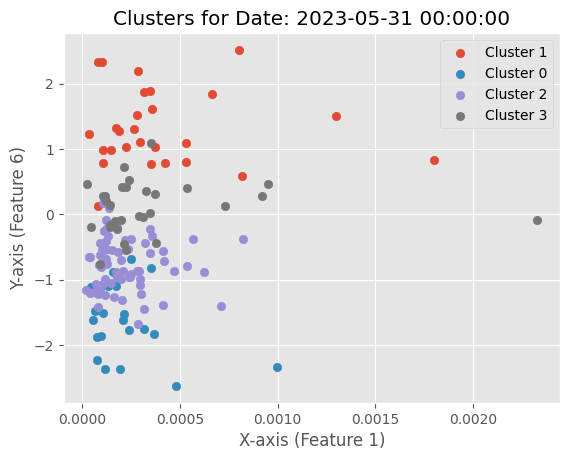

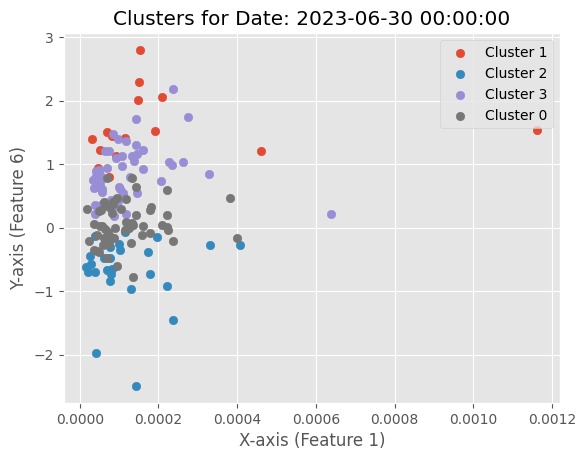

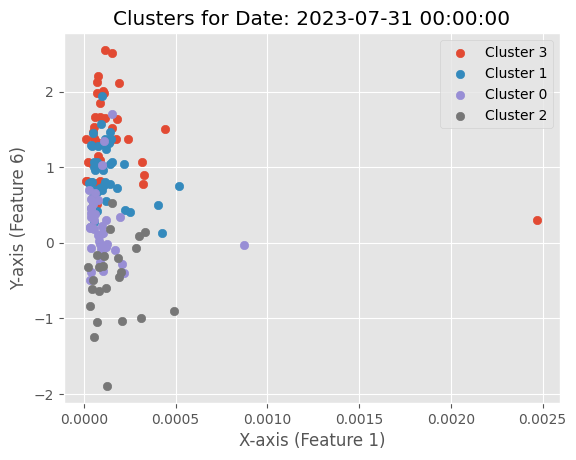

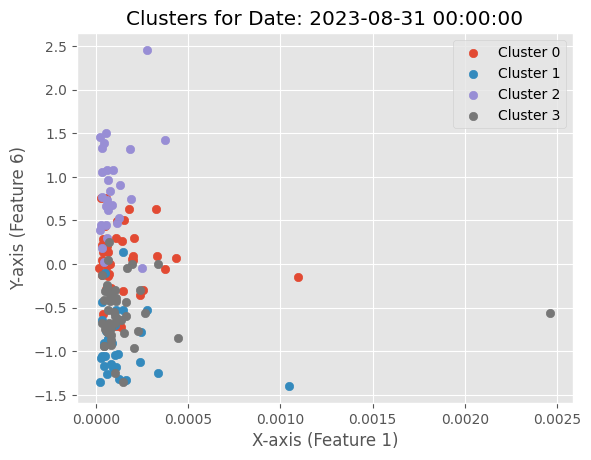

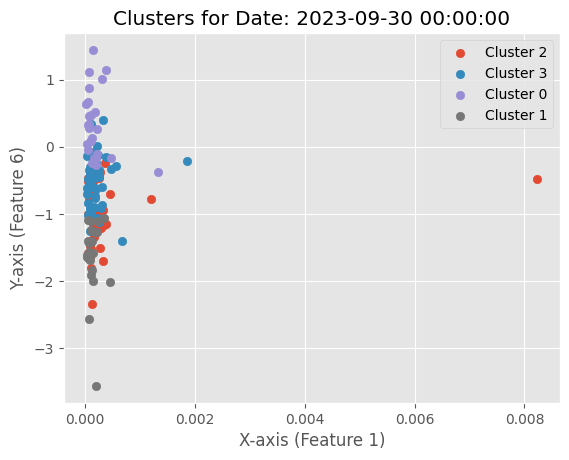

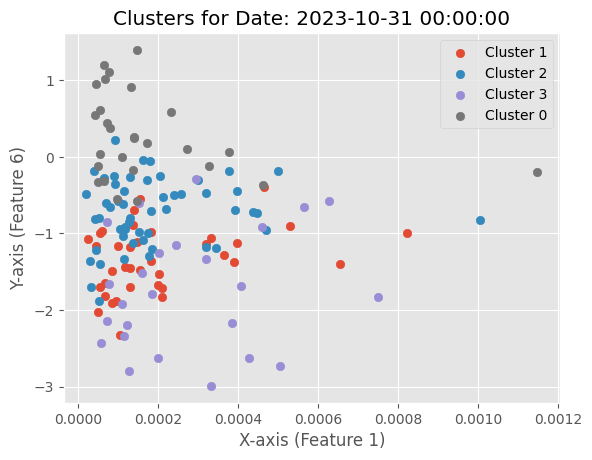

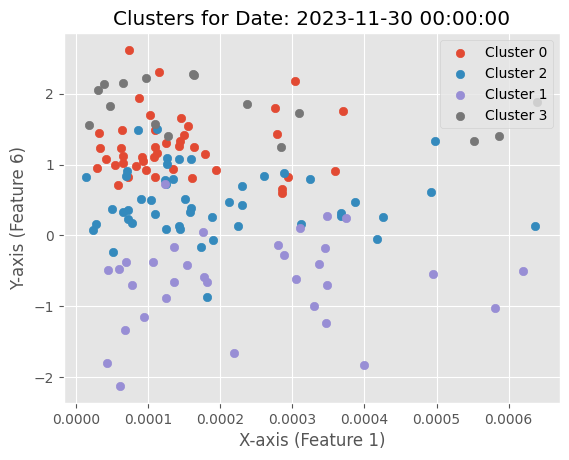

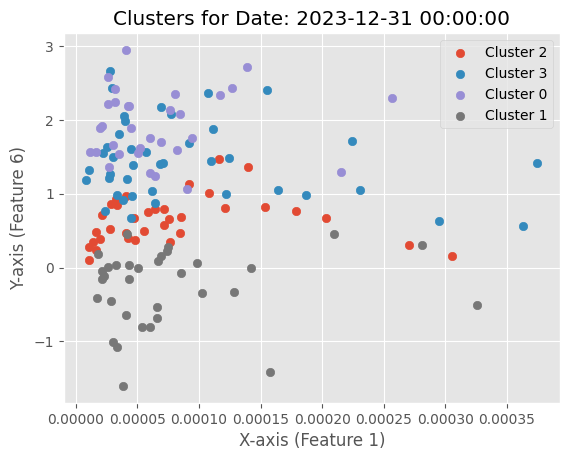

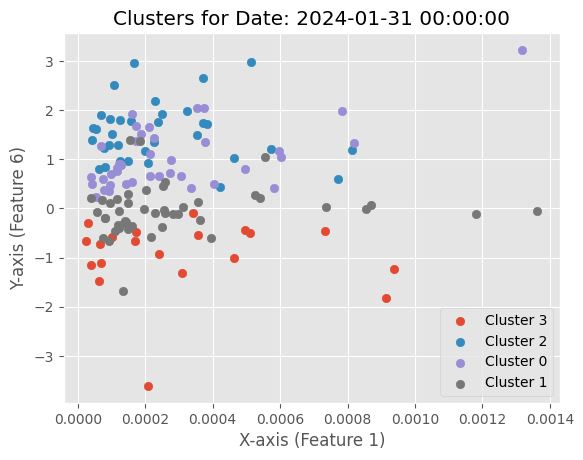

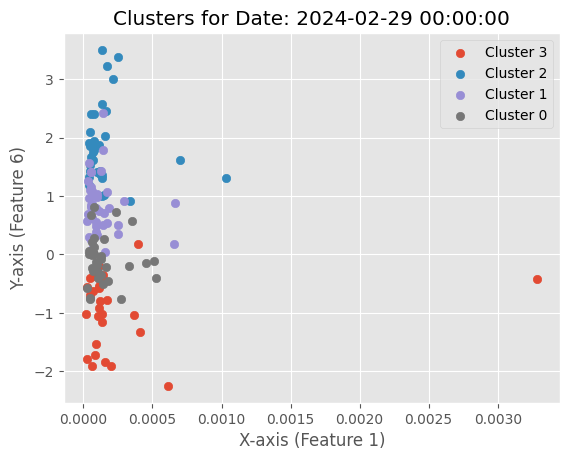

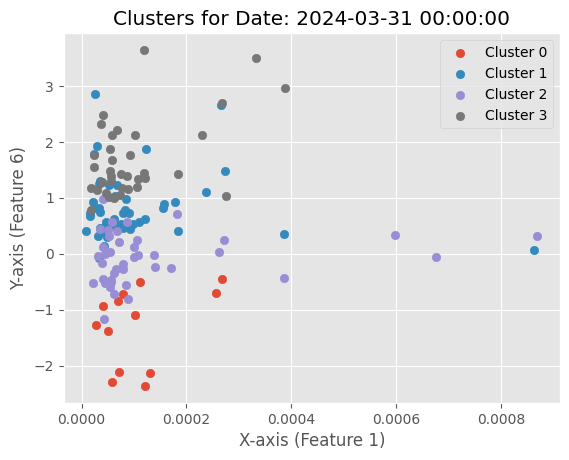

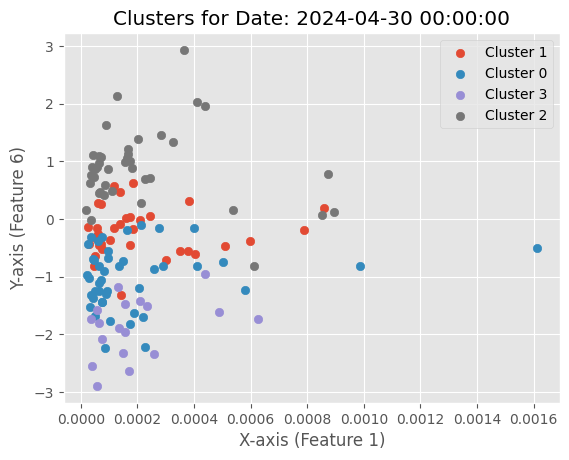

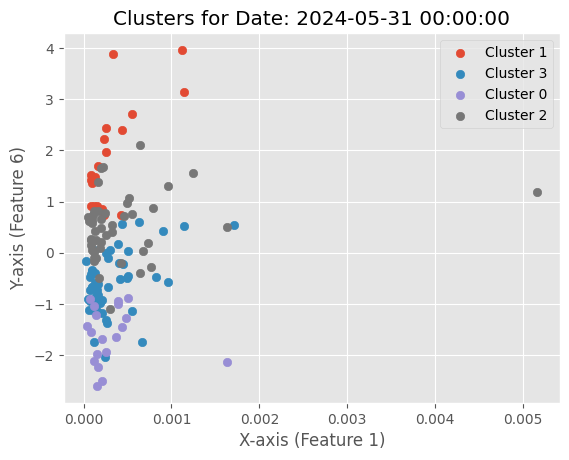

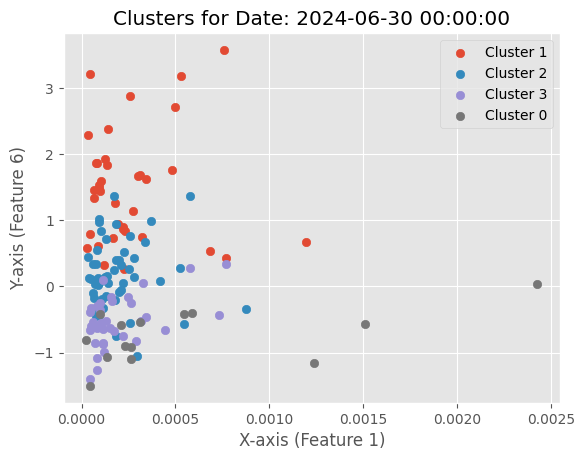

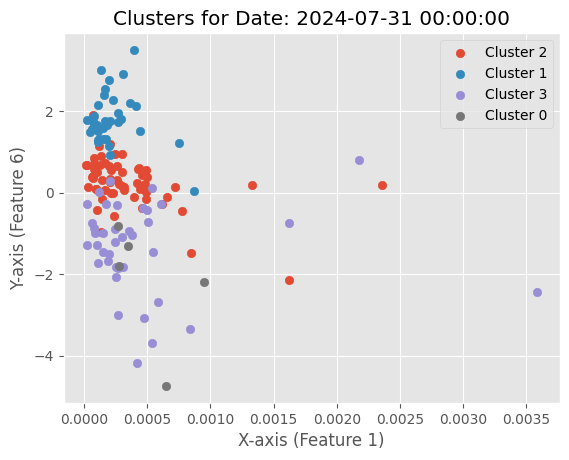

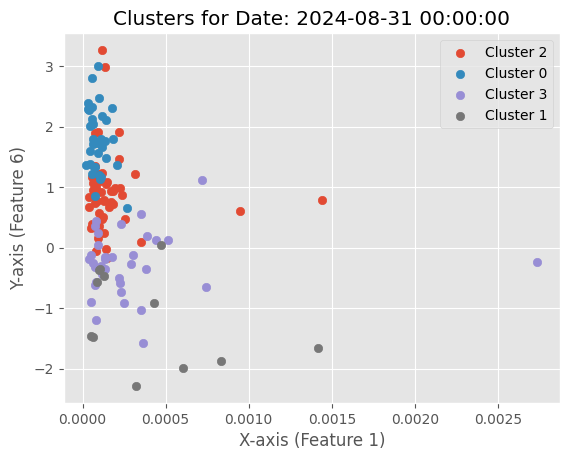

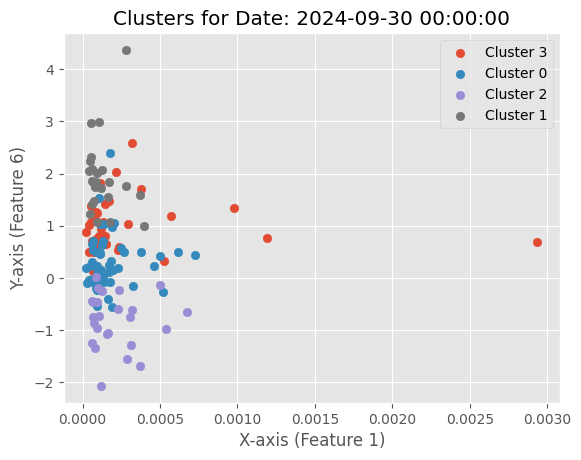

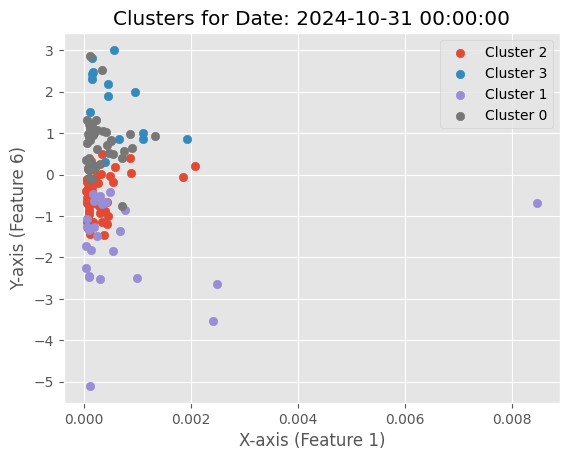

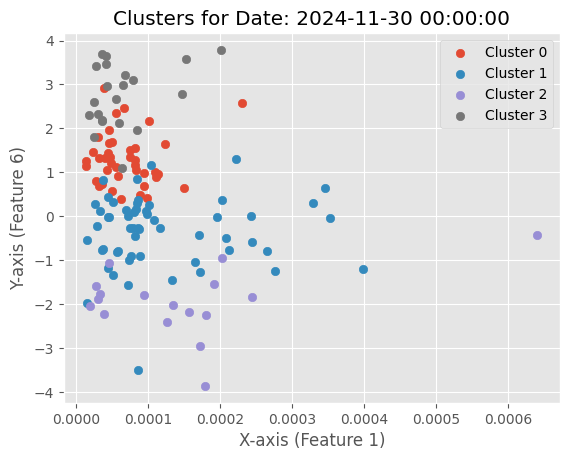

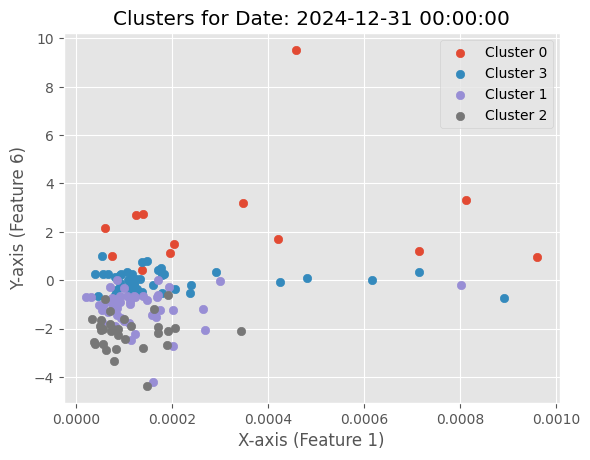

In [55]:
# def plot_clusters(data):

#     cluster_0 = data[data['cluster']==0]
#     cluster_1 = data[data['cluster']==1]
#     cluster_2 = data[data['cluster']==2]
#     cluster_3 = data[data['cluster']==3]

#     plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
#     plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
#     plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
#     plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
#     plt.legend()
#     plt.show()
#     return
# plt.style.use('ggplot')

# for i in data.index.get_level_values('date').unique().tolist():
    
#     g = data.xs(i, level=0)
    
#     plt.title(f'Date {i}')
    
#     plot_clusters(g)


# Define the function to plot clusters
def plot_clusters(data):
    """
    Plots the clusters in the given data. Assumes 'cluster' column exists
    and uses the first and seventh columns for X and Y axes.
    """
    for cluster_num in data['cluster'].unique():
        cluster = data[data['cluster'] == cluster_num]
        plt.scatter(
            cluster.iloc[:, 0], 
            cluster.iloc[:, 6], 
            label=f'Cluster {cluster_num}'
        )
    
    # Add legend and display the plot
    plt.legend()
    plt.xlabel('X-axis (Feature 1)')  # Replace with an actual column name if needed
    plt.ylabel('Y-axis (Feature 6)')  # Replace with an actual column name if needed
    plt.show()

# Set plot style
plt.style.use('ggplot')

# Loop through unique dates and plot clusters for each
for i in data.index.get_level_values('date').unique().tolist():
    # Extract data for the current date
    g = data.xs(i, level=0)
    
    # Set the plot title dynamically
    plt.title(f'Clusters for Date: {i}')
    
    # Plot clusters
    plot_clusters(g)


In [56]:
# Apply pre-defined centroids.
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
    First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

    Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [57]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2019-02-01': ['ABBV',
  'AMGN',
  'BMY',
  'CVS',
  'DAL',
  'DD',
  'FDX',
  'INTC',
  'MCD',
  'NVDA',
  'QCOM',
  'TSLA',
  'V',
  'VZ',
  'WBA'],
 '2019-03-01': ['AMAT',
  'AMGN',
  'AMZN',
  'BIIB',
  'BRK-B',
  'COP',
  'DAL',
  'DD',
  'DIS',
  'DLTR',
  'EA',
  'EXPE',
  'F',
  'FDX',
  'HAL',
  'HD',
  'JPM',
  'MDT',
  'MS',
  'NVDA',
  'OXY',
  'QCOM',
  'SCHW',
  'SLB',
  'STZ',
  'TSLA',
  'UAL',
  'VLO',
  'WBA'],
 '2019-04-01': ['AAPL',
  'ABT',
  'ADBE',
  'AMD',
  'AMZN',
  'CMCSA',
  'CSX',
  'CVX',
  'DAL',
  'EBAY',
  'FCX',
  'HD',
  'IBM',
  'INTC',
  'ISRG',
  'JNJ',
  'KO',
  'LLY',
  'LRCX',
  'MAR',
  'MSFT',
  'NEE',
  'NOW',
  'NVDA',
  'ORCL',
  'ORLY',
  'PANW',
  'PM',
  'QCOM',
  'RTX',
  'STZ',
  'T',
  'TJX',
  'UNP',
  'UPS',
  'VZ',
  'XOM'],
 '2019-05-01': ['AMGN',
  'BIIB',
  'COP',
  'HAL',
  'INTC',
  'ISRG',
  'LLY',
  'MMM',
  'OXY',
  'REGN',
  'TSLA',
  'UPS',
  'VRTX',
  'WBA'],
 '2019-06-01': ['AAPL',
  'ADI',
  'AMGN',
  'BA',
  'BAC',
 

Define portfolio optimization function
    We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

    To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

    Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [58]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()



In [59]:
# Download Fresh Daily Prices Data only for short listed stocks.

stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  153 of 153 completed


Price            Close                                                  \
Ticker            AAPL        ABBV         ABT         ACN        ADBE   
Date                                                                     
2018-01-31   39.388077   83.089943   55.294991  144.842697  199.759995   
2018-02-01   39.470417   86.140465   55.312790  144.626404  199.380005   
2018-02-02   37.757801   85.274170   54.876907  141.417694  195.639999   
2018-02-05   36.814445   81.083405   52.243813  136.847946  190.270004   
2018-02-06   38.352978   82.334694   52.359444  139.425766  194.470001   
...                ...         ...         ...         ...         ...   
2024-12-23  255.270004  178.389999  114.309998  358.769989  446.739990   
2024-12-24  258.200012  180.000000  114.760002  361.630005  447.940002   
2024-12-26  259.019989  179.199997  115.269997  360.429993  450.160004   
2024-12-27  255.589996  178.009995  114.989998  356.179993  446.480011   
2024-12-30  252.199997  176.199997  112.800003  352.489990  445.799988   

Price                                                                   ...  \
Ticker             ADI         ADP        ADSK        ALGN        AMAT  ...   
Date                                                                    ...   
2018-01-31   80.531433  106.707985  115.620003  262.000000   49.579918  ...   
2018-02-01   80.329819  103.937355  115.570000  255.570007   49.256336  ...   
2018-02-02   78.103561  102.340591  111.639999  257.380005   46.852695  ...   
2018-02-05   74.851791   98.456520  109.180000  242.399994   44.661674  ...   
2018-02-06   77.603958   97.489807  112.620003  241.449997   46.455173  ...   
...                ...         ...         ...         ...         ...  ...   
2024-12-23  214.889999  294.149994  297.489990  207.570007  167.460007  ...   
2024-12-24  218.089996  296.459991  301.230011  213.500000  168.369995  ...   
2024-12-26  218.059998  297.230011  300.279999  215.500000  167.550003  ...   
2024-12-27  216.990005  296.179993  297.589996  211.429993  166.830002  ...   
2024-12-30  212.559998  292.970001  297.529999  206.580002  163.639999  ...   

Price        Volume                                                            \
Ticker          VLO     VRTX        VZ       WBA     WDAY      WDC        WFC   
Date                                                                            
2018-01-31  5334000  2323800  17827000   6742400  1356100  8524300   18147900   
2018-02-01  5032300  5090000  18646100   5198400  1073200  3555200   15717600   
2018-02-02  4656700  3455100  15574000   7024800  1193900  5010400   18905300   
2018-02-05  7072900  2906900  22239600   7085900  1609800  5205200  103394400   
2018-02-06  6335000  3114600  34543900   6809100  2081400  4835800   83076900   
...             ...      ...       ...       ...      ...      ...        ...   
2024-12-23  2832600  2204300  21292300  18506100  3676000  4111200   11817000   
2024-12-24  1170100  1468600  11712200   8724500   850500  1512100    4442700   
2024-12-26  1884400  1191500  12946400  15705800  1243900  2146000    6964300   
2024-12-27  1697800  1373400  15168100  11621000  1602800  4161800    7219500   
2024-12-30  2890200  1456000  15672000  13992700  1755600  4410100    8443800   

Price                                     
Ticker           WMT      WYNN       XOM  
Date                                      
2018-01-31  29438400  11253100  14404700  
2018-02-01  19160400   6416100  17971000  
2018-02-02  27759300   5398800  29822100  
2018-02-05  37684800   4916800  30452700  
2018-02-06  49241400   3672700  36262800  
...              ...       ...       ...  
2024-12-23  26205400   1312400  12285100  
2024-12-24   8992400    692800   7807000  
2024-12-26  10994000   1218900   9652400  
2024-12-27  11384400   1086700  11943900  
2024-12-30   9790200   2180100  11080800  

[1740 rows x 765 columns]

In [60]:
# Calculate daily returns using log difference of adjusted closing prices
returns_dataframe = np.log(new_df['Close']).diff()

# Create an empty dataframe to store portfolio returns
portfolio_df = pd.DataFrame()

# Loop through each start date in the fixed_dates dictionary
for start_date in fixed_dates.keys():
    
    try:
        # Define the end date by adding a month to the start date
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        # Get the columns (tickers) for the current start date
        cols = fixed_dates[start_date]

        # Define the optimization window (12 months before the start date)
        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        # Define the optimization end date (one day before the start date)
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        # Extract adjusted close prices for the tickers during the optimization window
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Close'][cols]
        
        success = False
        try:
            # Attempt to optimize weights using a custom function 'optimize_weights'
            weights = optimize_weights(prices=optimization_df,
                                       lower_bound=round(1 / (len(optimization_df.columns) * 2), 3))

            # Convert the weights to a DataFrame
            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            # If optimization fails, print a message and continue with equal weights
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        # If optimization was unsuccessful, use equal weights for all tickers
        if not success:
            weights = pd.DataFrame([1 / len(optimization_df.columns) for _ in range(len(optimization_df.columns))],
                                   index=optimization_df.columns.tolist(),
                                   columns=pd.Series(0)).T
        
        # Extract the returns for the current month (from start_date to end_date)
        temp_df = returns_dataframe[start_date:end_date]

        # Stack the dataframe, reset index, and merge with weights
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0) \
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True) \
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        # Update the index names
        temp_df.index.names = ['date', 'ticker']

        # Calculate the weighted return for each ticker
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']

        # Group by date and sum the weighted returns to get the strategy return for each day
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        # Append the results to the portfolio dataframe
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        # Catch any errors and print them
        print(e)

# Drop any duplicate rows in the portfolio dataframe
portfolio_df = portfolio_df.drop_duplicates()

# Display the final portfolio returns dataframe
portfolio_df


# returns_dataframe = np.log(new_df['Close']).diff()

# portfolio_df = pd.DataFrame()

# for start_date in fixed_dates.keys():
    
#     try:

#         end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

#         cols = fixed_dates[start_date]

#         optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

#         optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
#         optimization_df = new_df[optimization_start_date:optimization_end_date]['Close'][cols]
        
#         success = False
#         try:
#             weights = optimize_weights(prices=optimization_df,
#                                    lower_bound=round(1/(len(optimization_df.columns)*2),3))

#             weights = pd.DataFrame(weights, index=pd.Series(0))
            
#             success = True
#         except:
#             print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
#         if success==False:
#             weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
#                                      index=optimization_df.columns.tolist(),
#                                      columns=pd.Series(0)).T
        
#         temp_df = returns_dataframe[start_date:end_date]

#         temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
#                    .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
#                           left_index=True,
#                           right_index=True)\
#                    .reset_index().set_index(['Date', 'index']).unstack().stack()

#         temp_df.index.names = ['date', 'ticker']

#         temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

#         temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

#         portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
#     except Exception as e:
#         print(e)

# portfolio_df = portfolio_df.drop_duplicates()

# portfolio_df

Max Sharpe Optimization failed for 2019-02-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2020-06-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in th

""


8. Visualize Portfolio returns and compare to SP500 returns.

In [61]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Close']]).diff().dropna().rename({'Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


MergeError: Not allowed to merge between different levels. (1 levels on the left, 2 on the right)

In [62]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

TypeError: cannot do slice indexing on RangeIndex with these indexers [2023-09-29] of type str

In [ ]:
print(new_df.columns)


In [ ]:
unique_values = np.unique(df['adj close'])
print("Unique values in adj close:", unique_values)
